In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
#from moviepy.editor import VideoFileClip
import glob
import time
import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def warpImage(image, src_points, dst_points):
    image_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    warped_image = cv2.warpPerspective(image, M,image_size, flags=cv2.INTER_LINEAR)
    return warped_image, M, Minv
def hlsLSelect(img, thresh=(220, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1] 
    l_channel = 255*(l_channel/np.max(l_channel))
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1 
    return binary_output
def hlsHSelect(img, thresh=(220, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h_channel = hls[:,:,0] 
    h_channel = 255*(h_channel/np.max(h_channel))
    binary_output = np.zeros_like(h_channel)
    binary_output[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1 
    return binary_output
def labBSelect(img, thresh=(195, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    lab_b = lab[:,:,2]
    if np.max(lab_b) > 100:#162
        lab_b = 255*(lab_b/np.max(lab_b))
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    return binary_output
def find_lane_pixels(binary_warped, nwindows, margin, minpix):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    #histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)#下半平面
    #histogram = np.sum(binary_warped[:,:binary_warped.shape[0]*5//6], axis=0)#左半平面
    histogram = np.sum(binary_warped[:,:], axis=0)#全平面
    midpoint = np.int(binary_warped.shape[1]//2)
    print("binary_waeped.shape",binary_warped.shape)
    print("histogram.shape",histogram.shape)
    print("midpoint=",midpoint)
    leftx_base = np.argmax(histogram[50:int(0.8*midpoint)])+50
    rightx_base = np.argmax(histogram[midpoint:int(1.8*midpoint)]) + midpoint


    print("leftx_base",leftx_base)
    print("rightx_base",rightx_base)
    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin##margin是滑动窗口宽度的一半
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        #cv2.imshow("out_img", out_img)
        #cv2.waitKey(0)
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
#         print("good_left_inds",good_left_inds)
#         print("good_right_inds",good_right_inds)
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
#     if len(left_lane_inds) == 0:
#         leftx = rightx - 260
#         lefty = righty
#     if len(right_lane_inds) == 0:
#         rightx = leftx + 260
#         righty = lefty
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, nwindows=9, margin=100, minpix=50):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(
        binary_warped, nwindows, margin, minpix)
    print('leftx:', leftx)
    print('lefty:', lefty)
    print('rightx:', rightx)
    print('righty:', righty)
    if len(leftx) == 0 and len(rightx) == 0:
        # 左右车道线均为空时
        out_img = np.zeros_like(binary_warped)
        left_fit = np.array([0, 0, binary_warped.shape[1]//2])
        right_fit = np.array([0, 0, binary_warped.shape[1]//2])
    elif len(leftx) == 0:
        # 左车道线为空时，将其设置为右车道线向左偏移280
        right_fit = np.polyfit(righty, rightx, 2)
        left_fit = np.array([right_fit[0], right_fit[1], right_fit[2]+280])
    elif len(rightx) == 0:
        # 右车道线为空时，将其设置为左车道线向右偏移280
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.array([left_fit[0], left_fit[1], left_fit[2]-280])
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    print('left shape:', left_fit.shape)
    print('left type:', type(left_fit))
    print("left_fit",left_fit)
    print("right_fit",right_fit)
    return out_img, left_fit, right_fit, ploty

# def fit_polynomial(binary_warped, nwindows=9, margin=100, minpix=50):
#     leftx, lefty, rightx, righty, out_img = find_lane_pixels(
#         binary_warped, nwindows, margin, minpix)
#     print('leftx:', leftx)
#     print('lefty:', lefty)
#     print('rightx:', rightx)
#     print('righty:', righty)
#     if len(leftx) == 0 and len(rightx) == 0:
#         # 左右车道线均为空时
#         out_img = np.zeros_like(binary_warped)
#         left_fit = np.array([0, 0, binary_warped.shape[1]//2])
#         right_fit = np.array([0, 0, binary_warped.shape[1]//2])
#     elif len(leftx) == 0:
#         # 左车道线为空时，将其设置为右车道线向左偏移260
#         right_fit = np.polyfit(righty, rightx, 2)
#         left_fit = np.array([right_fit[0], right_fit[1], right_fit[2]+260])
#         leftx = np.int32(right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]) + 260
#         lefty = righty
#     elif len(rightx) == 0:
#         # 右车道线为空时，将其设置为左车道线向右偏移260
#         left_fit = np.polyfit(lefty, leftx, 2)
#         right_fit = np.array([left_fit[0], left_fit[1], left_fit[2]-260])
#         rightx = np.int32(left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]) - 260
#         righty = lefty
#     else:
#         left_fit = np.polyfit(lefty, leftx, 2)
#         right_fit = np.polyfit(righty, rightx, 2)
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     out_img[lefty, leftx] = [255, 0, 0]
#     out_img[righty, rightx] = [0, 0, 255]
#     print('leftx:', leftx)
#     print('lefty:', lefty)
#     print('rightx:', rightx)
#     print('righty:', righty)
#     print('left shape:', left_fit.shape)
#     print('left type:', type(left_fit))
#     return out_img, left_fit, right_fit, ploty


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit, right_fit):
    margin = 60
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result, left_fit, right_fit, ploty
def CalculateDistFromCenter(binary_image, left_fit, right_fit):
    img_size = (binary_image.shape[1], binary_image.shape[0])
    dist_from_center = 0.0
    if right_fit is not None:
        if left_fit is not None:
            camera_pos = img_size[0] / 2
            left_lane_pix = np.polyval(left_fit, binary_image.shape[0])
            right_lane_pix = np.polyval(right_fit, binary_image.shape[0])
            center_of_lane_pix = (left_lane_pix + right_lane_pix) / 2
            dist_from_center = (camera_pos - center_of_lane_pix) * 325/400 #mm
    return  dist_from_center
def drawing(undist, bin_warped, color_warp, left_fitx, right_fitx, ploty, Minv):
    warp_zero = np.zeros_like(bin_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result
def overlay_text_on_image (image, dist_from_center, fps):
    new_img = np.copy(image)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_color = (255,255,255)
    num_format = '{:04.2f}'
    text = 'FPS: ' + str(fps)
    cv2.putText(new_img, text, (40,70), font, 1.5, font_color, 2, cv2.LINE_AA)
    direction = 'left'
    if dist_from_center > 0:
        direction = 'right'
    abs_dist = abs(dist_from_center)
    text = 'Vehicle is ' + num_format.format(abs_dist) + ' mm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, font_color, 2, cv2.LINE_AA)
    return new_img

In [3]:
wrap_offset = 150
#src = np.float32([[262-wrap_offset, 368], [392+wrap_offset, 368], [535+wrap_offset, 480], [135-wrap_offset, 480]])
#src = np.float32([[300-wrap_offset, 368], [350+wrap_offset, 368], [535+wrap_offset, 480], [135-wrap_offset, 480]])
#src=np.float32([[170,320],[450,320],[600,380],[0,380]])#看路沿
src=np.float32([[168,325],[430,325],[550,395],[0,395]])#看路沿
dst = np.float32([[wrap_offset, 0], [640-wrap_offset, 0], [640-wrap_offset, 640], [wrap_offset, 640]])#最初 wrap_offset=150
#dst = np.float32([[wrap_offset, 0], [200-wrap_offset, 0], [200-wrap_offset, 360], [wrap_offset, 360]])
#dst = np.float32([[wrap_offset, 0], [550-wrap_offset, 0], [550-wrap_offset, 640], [wrap_offset, 640]])
undistort_image=cv2.imread("D:\模式识别与机器学习\data\image\直道.jpg")
warp_image, M, Minv = warpImage(undistort_image, src, dst)
cv2.imshow("warp_image",warp_image)


#步骤4-提取车道线
hlsL_binary = hlsLSelect(warp_image,(160,255))
#hlsL_binary = hlsLSelect(warp_image,(150,255))
combined_binary = np.zeros_like(hlsL_binary)
labB_binary=0
combined_binary[(hlsL_binary == 1)] = 1

cv2.imshow("combined_binary_before",combined_binary)
combined_binary = np.uint8(255 * combined_binary)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(combined_binary)

#定义面积阈值
area_threshold = 10

# 遍历每个连通域
for i in range(1, num_labels):
    # 获取该连通域的面积
    area = stats[i, cv2.CC_STAT_AREA]
    # 如果该连通域的面积小于阈值，或者大于阈值，则将该连通域内的所有像素置为黑色
    if area < area_threshold or area > 5000:
        combined_binary[labels == i] = 0

# min_size_threshold = 35

# # 遍历每个连通域
# for i in range(1, num_labels):
#     # 获取该连通域的左上角坐标和宽高
#     x, y, w, h = stats[i, cv2.CC_STAT_LEFT:cv2.CC_STAT_HEIGHT+1]
#     # 如果该连通域的宽度或高度的最小值大于阈值，则将该连通域内的所有像素置为黑色
#     if min(w, h) > min_size_threshold:
#         combined_binary[y:y+h, x:x+w] = 0

# # 遍历每个连通域
# width_threshold=5
# for i in range(1, num_labels):
#     # 获取该连通域的左上角坐标和宽高
#     x, y, w, h = stats[i, cv2.CC_STAT_LEFT:cv2.CC_STAT_HEIGHT+1]
#     flag = False  # 标志当前连通域内是否存在符合条件的行
#     # 遍历该连通域中的每一行
#     for j in range(y, y+h):
#         # 获取该行的宽度
#         width = w - (j - y)
#         # 如果该行的宽度大于阈值，则将 flag 置为 True，中断循环
#         if width > width_threshold:
#             flag = True
#             break
#     # 如果当前连通域内存在符合条件的行，则将该连通域内的所有像素置为黑色
#     if flag:
#         combined_binary[y:y+h, x:x+w] = 0

cv2.imshow("combined_binary",combined_binary)
print("combined_binary.shape",combined_binary.shape)

detected = False
left_fit = []
right_fit = []
ploty = []
if detected == False:#步骤5-滑动窗口检测车道线
    out_img, left_fit, right_fit, ploty = fit_polynomial(combined_binary, nwindows=9, margin=20, minpix=40)
    cv2.imshow("out_img",out_img)
    cv2.waitKey(0)
    if left_fit[0] == 0 and left_fit[1] == 0:
        detected = False
    else :
        detected = True
    print("detected",detected)
else:#步骤6-追踪车道线
    track_result, left_fit, right_fit, ploty,  = search_around_poly(combined_binary, left_fit, right_fit)
    if (len(left_fit) > 0 & len(right_fit) > 0) :
        detected = True
    else :
        detected = False

 # step 7-CalculateDistFromCenter
dist_from_center = CalculateDistFromCenter(warp_image, left_fit, right_fit)

AttributeError: 'NoneType' object has no attribute 'shape'

In [31]:
    #步骤8-逆透视变换 and drawing 
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    result = drawing(undistort_image, combined_binary, warp_image, left_fitx, right_fitx, ploty, Minv)
    #step 9-show text 
    result = overlay_text_on_image (result, dist_from_center, fps=0)
    #cv2.imshow("result",result)

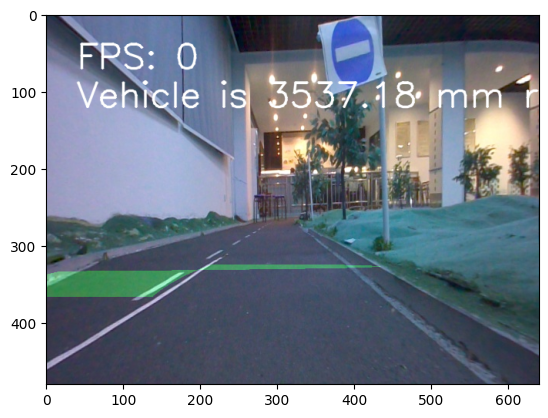

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(result)
plt.show()

In [11]:
dist_from_center

-74.28605799219494